<a href="https://colab.research.google.com/github/Macarena6MiMa/ProyectoML/blob/main/PrimeraEtapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Cargar y visualizar señales ECG

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


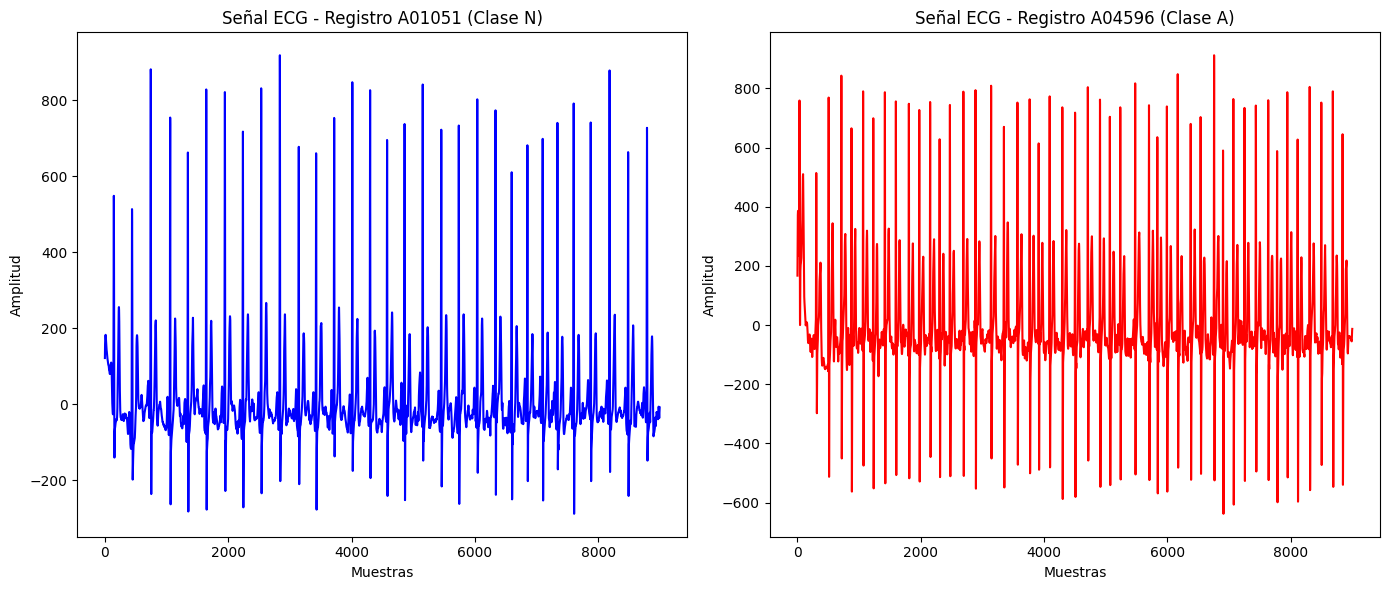

In [6]:
import os
import pandas as pd
import numpy as np
from scipy.io import loadmat
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

# 1. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Ruta al directorio de datos en tu Google Drive
data_dir = r'/content/drive/MyDrive/ColabNotebooks/ECG_Proyecto/training2017/training2017'

mat_files = [f for f in os.listdir(data_dir) if f.endswith('.mat')]

# Cargar archivo REFERENCE.csv
reference_path = os.path.join(data_dir, 'REFERENCE.csv')
df_labels = pd.read_csv(reference_path, header=None, names=['registro', 'clase'])

feature_rows = []

for mat_file in mat_files:
    registro = mat_file.replace('.mat', '')
    mat_path = os.path.join(data_dir, mat_file)
    hea_path = os.path.join(data_dir, registro + '.hea')

    # Cargar señal
    mat_data = loadmat(mat_path)
    if 'val' not in mat_data:
        print(f"'val' key not found in {mat_file}")
        continue
    signal = mat_data['val'].flatten()

    # Cargar frecuencia de muestreo
    import os

    hea_path = os.path.join(data_dir, registro + '.hea')
    if not os.path.exists(hea_path):
      continue

    with open(hea_path, 'r') as f:
        fs = int(f.readline().split()[2])

    duracion_seq = len(signal) / fs
    media_mv = np.mean(signal)
    mstd_mv = np.std(signal)
    sk = skew(signal)
    kurt = kurtosis(signal)

    peaks, _ = find_peaks(signal, distance=fs*0.3)
    rr_intervals = np.diff(peaks) / fs if len(peaks) > 1 else [np.nan]
    rr_mean_s = np.mean(rr_intervals)
    rr_std_s = np.std(rr_intervals)
    # Buscar clase
    clase_row = df_labels[df_labels['registro'] == registro]
    clase = clase_row['clase'].values[0] if not clase_row.empty else 'Desconocida'

    feature_rows.append({
        'registro': registro,
        'fs': fs,
        'duracion_seq': duracion_seq,
        'media_mv': media_mv,
        'mstd_mv': mstd_mv,
        'skewness': sk,
        'kurtosis': kurt,
        'rr_mean_s': rr_mean_s,
        'rr_std_s': rr_std_s,
        'clase': clase
    })

# 5. Crear DataFrame final
df_features = pd.DataFrame(feature_rows)

# 6. Seleccionar un registro aleatorio de clase N y A
df_n = df_features[df_features['clase'] == 'N']
df_a = df_features[df_features['clase'] == 'A']

if len(df_n) == 0 or len(df_a) == 0:
    print("No hay suficientes registros de clase N y A para graficar.")
else:
    registro_n = df_n.sample(n=1, random_state=42)['registro'].values[0]
    registro_a = df_a.sample(n=1, random_state=42)['registro'].values[0]

    # 7. Cargar señales
    signal_n = loadmat(os.path.join(data_dir, registro_n + '.mat'))['val'].flatten()
    signal_a = loadmat(os.path.join(data_dir, registro_a + '.mat'))['val'].flatten()

    # 8. Visualización
    plt.figure(figsize=(14, 6))

    # Señal N
    plt.subplot(1, 2, 1)
    plt.plot(signal_n, color='blue')
    plt.title(f'Señal ECG - Registro {registro_n} (Clase N)')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')

    # Señal A
    plt.subplot(1, 2, 2)
    plt.plot(signal_a, color='red')
    plt.title(f'Señal ECG - Registro {registro_a} (Clase A)')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')

    plt.tight_layout()
    plt.show()


2.Inspección básica del dataset

In [7]:
# Guardar resultados
df_features = pd.DataFrame(feature_rows)
df_features.to_csv(os.path.join(data_dir, 'caracteristicas_entrenamiento_con_clase.csv'), index=False)
# Mostrar primeras filas
print(df_features.head())
#a partir del csv generado, seleccionar 30 registros, 15 de cada clase (N y A) de forma aleatoria
output_path = os.path.join(data_dir, 'caracteristicas_entrenamiento_con_clase.csv')
# Cargar el CSV generado
df_features = pd.read_csv(output_path)
# Filtrar registros por clase
df_clase_1 = df_features[df_features['clase'].str.startswith('N')]
df_clase_2 = df_features[df_features['clase'].str.startswith('A')]
print("Registros que comienzan con 'N':", len(df_clase_1))
print("Registros que comienzan con 'A':", len(df_clase_2))

# Seleccionar 15 registros aleatorios de cada clase
selected_clase_1 = df_clase_1.sample(n=15, random_state=42)
selected_clase_2 = df_clase_2.sample(n=15, random_state=42)
# Concatenar los registros seleccionados
df_selected = pd.concat([selected_clase_1, selected_clase_2], ignore_index=True)
# Guardar el DataFrame seleccionado
output_selected_path = os.path.join(data_dir, 'caracteristicas_entrenamiento_seleccionadas.csv')
df_selected.to_csv(output_selected_path, index=False)
# Cargar el CSV de registros seleccionados
df_selected = pd.read_csv(output_selected_path)
#mostrar las primeras 30 filas del DataFrame seleccionado
print(df_selected.head())
print("\nResumen estadístico de las variables numéricas:")
print(df_selected.describe())

  registro   fs  duracion_seq   media_mv     mstd_mv  skewness   kurtosis  \
0   A08031  300     60.000000   1.372444  150.909889 -0.849547   8.969840   
1   A08018  300     21.240000  43.243409  571.619699  0.847149   1.010840   
2   A08035  300     30.000000  20.407556  181.652904 -0.226129   1.197200   
3   A08028  300     26.506667  40.288732  551.727797  1.812896  23.257730   
4   A08019  300     19.460000 -20.910586   85.195424 -0.698334   2.213176   

   rr_mean_s  rr_std_s clase  
0   0.451717  0.117676     N  
1   0.488450  0.133280     A  
2   0.461198  0.071626     ~  
3   0.429180  0.118872     N  
4   0.412246  0.092809     O  
Registros que comienzan con 'N': 5050
Registros que comienzan con 'A': 738
  registro   fs  duracion_seq   media_mv     mstd_mv  skewness   kurtosis  \
0   A01051  300     30.000000   9.317444  122.448214  3.444926  16.099658   
1   A07312  300     15.413333  11.819204  176.903666  0.639741   5.858984   
2   A08145  300     30.000000  25.125889  129

3.Visualización de distribuciones

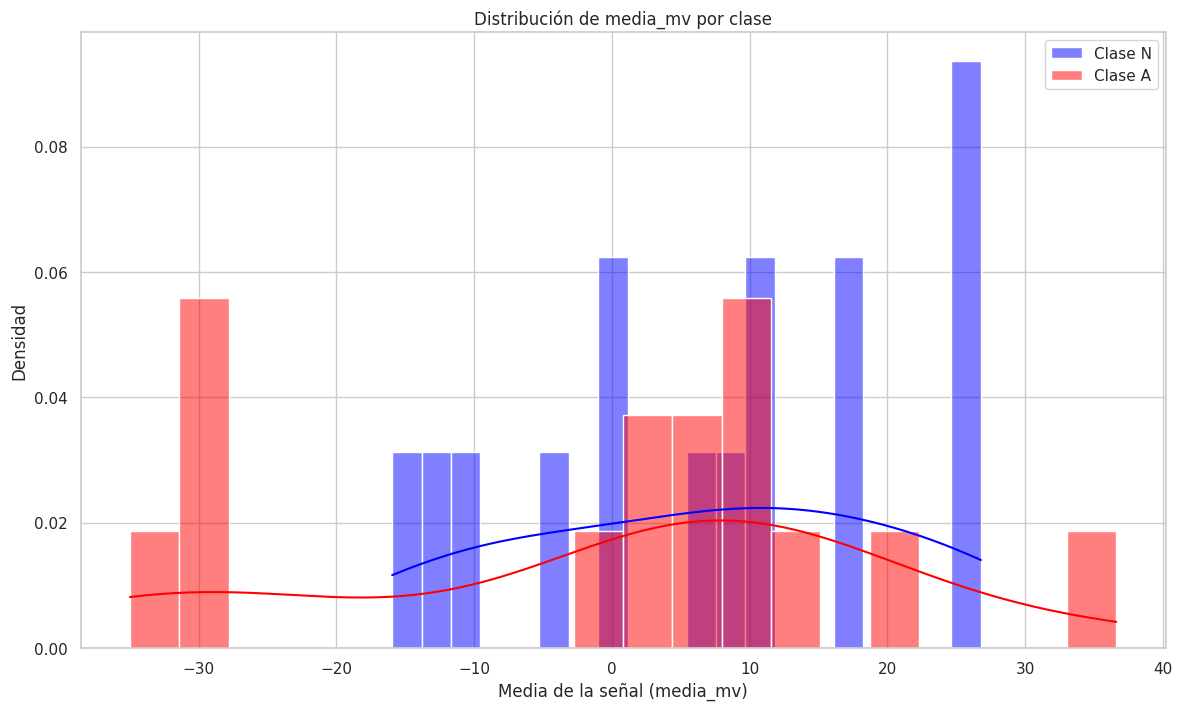

In [8]:
#mostrar estadísticas descriptivas y con su curva normal con histogramas con transparencia y descripción y separados por colores para cada clase, rojo para A y azul N, pero en el mismo histograma
import matplotlib.pyplot as plt
import seaborn as sns
# Configuración de estilo
sns.set(style="whitegrid")
# Crear figura y ejes
plt.figure(figsize=(14, 8))
# Histograma de 'media_mv' para clase N
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['media_mv'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'media_mv' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['media_mv'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de media_mv por clase')
plt.xlabel('Media de la señal (media_mv)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()


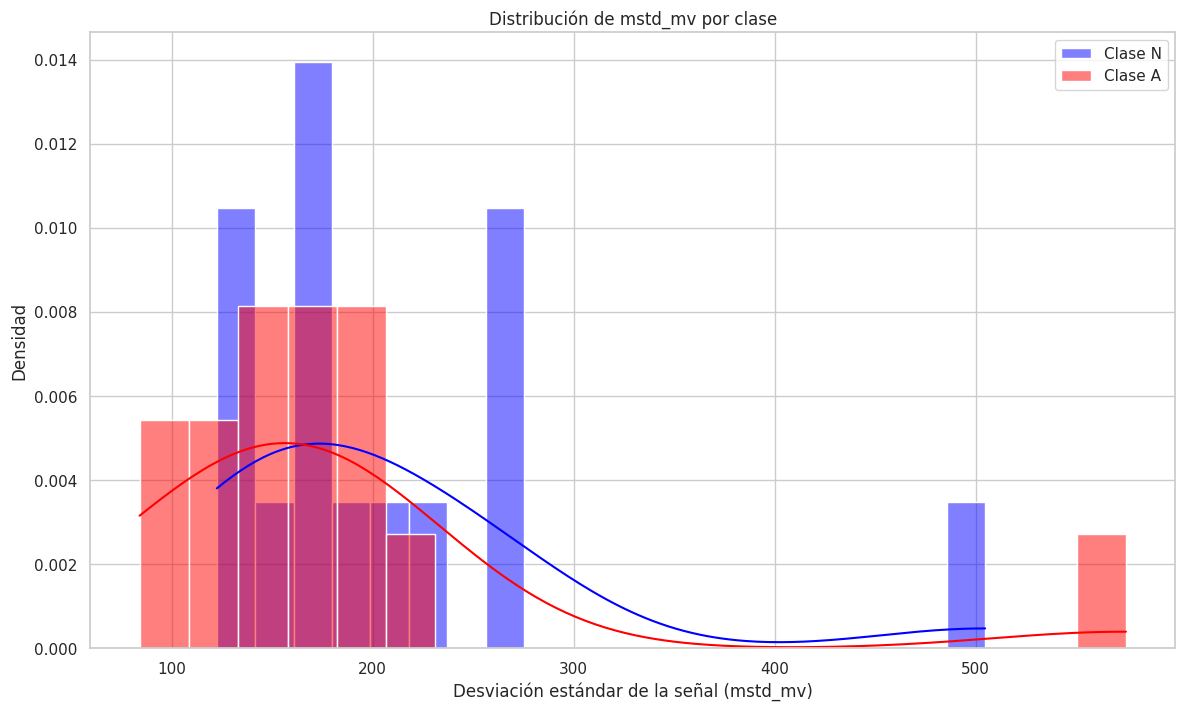

In [9]:
# Histograma de 'mstd_mv' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['mstd_mv'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'mstd_mv' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['mstd_mv'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de mstd_mv por clase')
plt.xlabel('Desviación estándar de la señal (mstd_mv)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

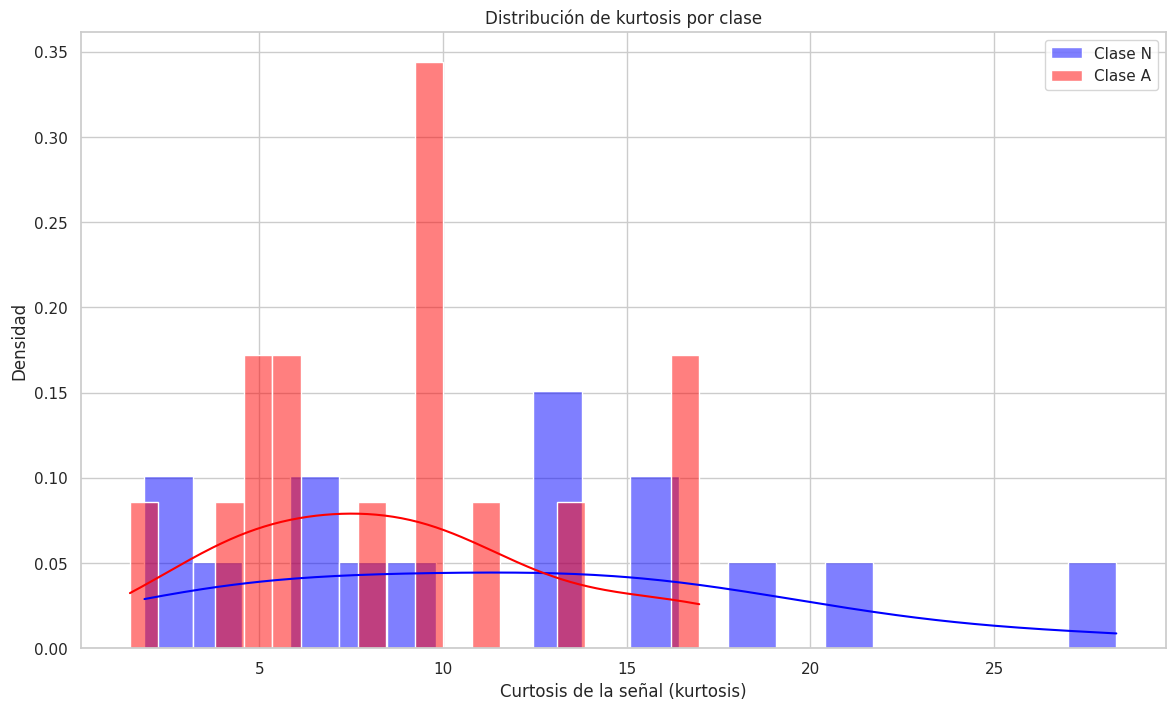

In [10]:
# Histograma de 'kurtosis' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['kurtosis'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'kurtosis' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['kurtosis'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de kurtosis por clase')
plt.xlabel('Curtosis de la señal (kurtosis)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

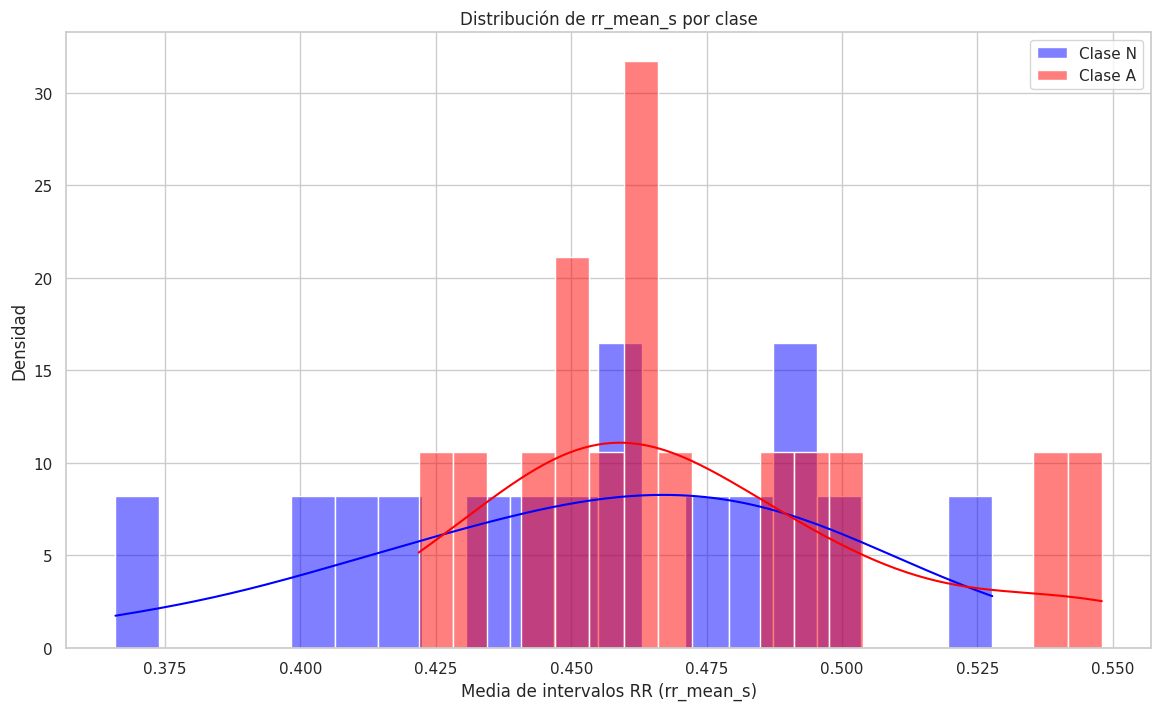

In [11]:
# Histograma de 'rr_mean_s' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['rr_mean_s'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'rr_mean_s' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['rr_mean_s'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de rr_mean_s por clase')
plt.xlabel('Media de intervalos RR (rr_mean_s)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

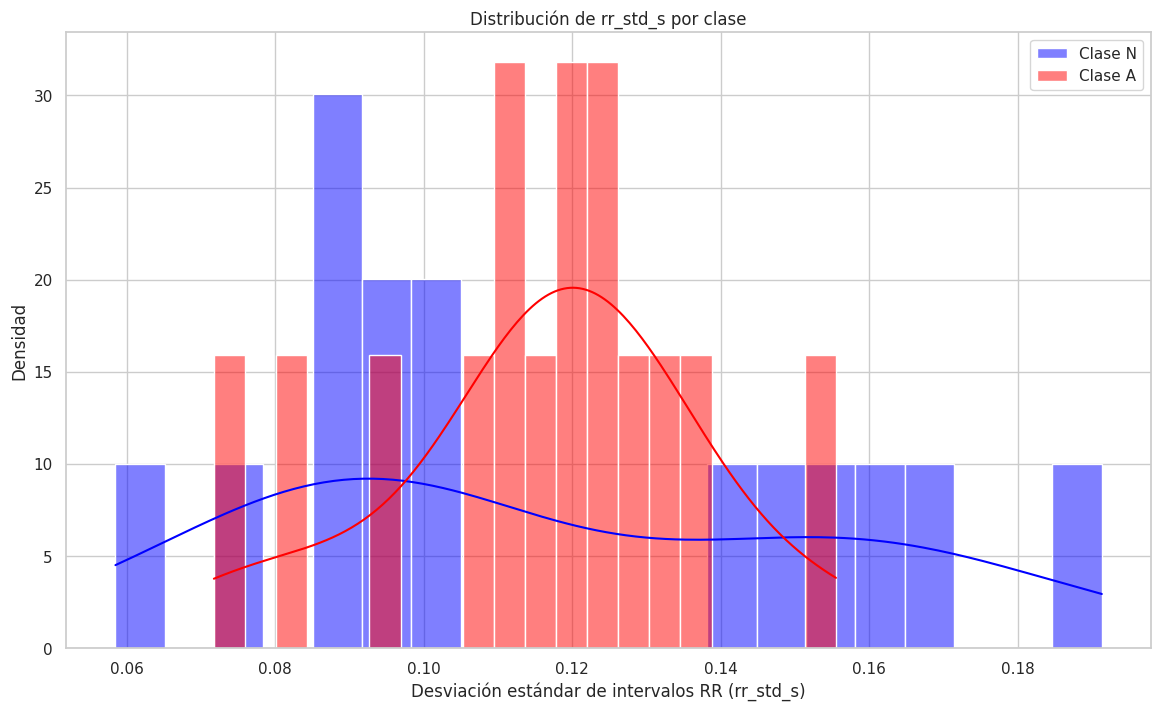

In [12]:
# Histograma de 'rr_std_s' para clase N
plt.figure(figsize=(14, 8))
sns.histplot(df_selected[df_selected['clase'].str.startswith('N')]['rr_std_s'],
             color='blue', label='Clase N', kde=True, stat='density', alpha=0.5, bins=20)
# Histograma de 'rr_std_s' para clase A
sns.histplot(df_selected[df_selected['clase'].str.startswith('A')]['rr_std_s'],
             color='red', label='Clase A', kde=True, stat='density', alpha=0.5, bins=20)
# Añadir título y etiquetas
plt.title('Distribución de rr_std_s por clase')
plt.xlabel('Desviación estándar de intervalos RR (rr_std_s)')
plt.ylabel('Densidad')
# Añadir leyenda
plt.legend()
# Mostrar gráfico
plt.show()

¿Qué variables parecen diferenciar más entre clases?

Las variables que parecen diferenciar más entre las clases N y A, basándonos en los histogramas y la distribución de los datos, son:
1. **Media de la señal (media_mv)**: La clase N muestra una distribución más concentrada y menos dispersa en comparación con la clase A, que tiene una mayor variabilidad.
2. **Desviación estándar de la señal (mstd_mv)**: Similar a la media, la clase N tiene una desviación estándar más baja, lo que indica menos variabilidad en la señal.
3. **Asimetría (skewness)**: La clase N tiende a tener una asimetría más cercana a cero, mientras que la clase A muestra una mayor asimetría, lo que indica que la distribución de los datos es más sesgada.
4. **Curtosis (kurtosis)**: La clase N tiene una curtosis más baja, lo que sugiere que la distribución es más plana en comparación con la clase A, que muestra picos más altos.
5. **Media de intervalos RR (rr_mean_s)**: La clase N tiene una media de intervalos RR más baja, lo que indica un ritmo cardíaco más regular en comparación con la clase A.
6. **Desviación estándar de intervalos RR (rr_std_s)**: La clase N muestra una desviación estándar más baja, lo que sugiere menos variabilidad en los intervalos RR en comparación con la clase A.


¿Qué aspectos del dataset llaman la atención?

Algunos aspectos que pueden llamar la atención del dataset son:
1. Desbalance de clases: Si hay una diferencia significativa en el número de registros entre las clases 'N' y 'A', esto puede afectar el rendimiento del modelo.
2. Distribución de características: Las distribuciones de las características como 'media_mv', 'mstd_mv', 'skewness', 'kurtosis', 'rr_mean_s' y 'rr_std_s' pueden mostrar diferencias significativas entre las clases, lo que puede ser útil para la clasificación.
4. Duración de las secuencias: La duración de las secuencias puede variar entre registros, lo que podría influir en el análisis temporal.
5. Comparación de estadísticas descriptivas: Las estadísticas descriptivas como la media, desviación estándar, asimetría y curtosis pueden proporcionar información sobre la naturaleza de las señales en cada clase.
6. Comportamiento de los intervalos RR: La media y desviación estándar de los intervalos RR pueden proporcionar información sobre la variabilidad de la frecuencia cardíaca en cada clase.
7. Visualización de distribuciones: Los histogramas y gráficos de densidad pueden ayudar a visualizar las diferencias en la distribución de las características entre las clases.
8. Comparación de clases: La comparación entre las clases 'N' y 'A' en términos de características puede revelar diferencias significativas que pueden ser útiles para la clasificación.
9. Análisis de la variabilidad de la frecuencia cardíaca: La variabilidad de la frecuencia cardíaca puede ser un indicador importante de la salud cardiovascular y puede variar entre las clases.